In [1]:
# Read me: 
"""
This Notebook uses 'yellow_tripdata_2013-05.csv' dataset which 
represent real taxi calls over manhetten recorded for may 2013
You can download it here: https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2013-05.csv

How to use : 
1) Download: the csv from the link above.
2) Location: The file must be in the same directory as this notebook.
3) Run: Run all cell consecutively.


Returned values:
1) "clean_2013.csv" : all valid trips from 0000 hours Sunday, May 5,2013, to 2359 hours, Saturday May 11, 2013.
    This used to create "Request nodes" in the project , and containes 4 columns:
    
    a)   request_Index: Natural .
    b)   pickup_datetime : pd.Timestamp .
    c&d) src and dst: both : Natural .
    
    !!!! IMPORTANT !!!!
   (src and dst node ID's are matching this graph: 
    G = ox.graph_from_place('Manhattan, New York City, New York, USA', network_type='drive'))
    
2) "all_paths_nyc.pickle" : Dictionary, keyed by source and target, of shortest paths.
    display the path as a list of node ID's.


3) "all_travel_times.pickle ": (source, dictionary) iterator with dictionary keyed by target and shortest path length as the key value.

How to use : 
1) Download: the csv from the link above.
2) Location: The file must be in the same directory as this notebook.
3) Run: Run all cell consecutively.


Enjoy (=
"""


'\nThis Notebook uses \'yellow_tripdata_2013-05.csv\' dataset which \nrepresent real taxi calls over manhetten recorded for may 2013\nYou can download it here: https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2013-05.csv\n\nHow to use : \n1) Download: the csv from the link above.\n2) Location: The file must be in the same directory as this notebook.\n3) Run: Run all cell consecutively.\n\n\nReturned values:\n1) "clean_2013.csv" : all valid trips from 0000 hours Sunday, May 5,2013, to 2359 hours, Saturday May 11, 2013.\n    This used to create "Request nodes" in the project , and containes 4 columns:\n    \n    a)   request_Index: Natural .\n    b)   pickup_datetime : pd.Timestamp .\n    c&d) src and dst: both : Natural .\n    \n    !!!! IMPORTANT !!!!\n   (src and dst node ID\'s are matching this graph: \n    G = ox.graph_from_place(\'Manhattan, New York City, New York, USA\', network_type=\'drive\'))\n    \n2) "all_paths_nyc.pickle" : Dictionary, keyed by source and target, 

In [2]:
import pandas as pd
import collections
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__
import pandas as pd
import datetime
from datetime import datetime
from datetime import timedelta
import pickle
from multiprocessing import Process, Manager


In [3]:
# Making request from real nyc taxi data , for Simulation

In [4]:
# Getting the Data
df2013 = pd.read_csv('yellow_tripdata_2013-05.csv')
# Sorting by pickupo time
df2013 = df2013.sort_values(by=['pickup_datetime'])
print(df2013.head())

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


         vendor_id      pickup_datetime     dropoff_datetime  passenger_count  \
10661523       VTS  2013-05-01 00:00:00  2013-05-01 00:12:00                1   
10638632       VTS  2013-05-01 00:00:00  2013-05-01 00:24:00                1   
10634665       VTS  2013-05-01 00:00:00  2013-05-01 00:07:00                1   
10634664       VTS  2013-05-01 00:00:00  2013-05-01 00:08:00                1   
10643988       VTS  2013-05-01 00:00:00  2013-05-01 00:27:00                3   

          trip_distance  pickup_longitude  pickup_latitude  rate_code  \
10661523           2.61        -73.986757        40.742767          1   
10638632          12.90        -73.988747        40.736955          1   
10634665           2.60        -73.991260        40.745135          1   
10634664           1.29        -74.000580        40.742137          1   
10643988           6.48        -73.983583        40.761282          1   

         store_and_fwd_flag  dropoff_longitude  dropoff_latitude payment_t

In [5]:
# Parser func
def str_to_time(s):
    t = pd.Timestamp(s)
    tt = t.to_pydatetime()
    return tt
    
def str_to_time_list(s):
    time_list = []
    for t_string in s :
        time_list.append(str_to_time(t_string))
    return time_list

In [6]:
# Parse pickup_datetime string to pd.Timestamp()
df2013['pickup_datetime'] =str_to_time_list(df2013['pickup_datetime'])
df2013['dropoff_datetime'] =str_to_time_list(df2013['dropoff_datetime']) 

In [8]:
# Filter only the requests from 0000 hours Sunday, May 5,2013, to 2359 hours, Saturday May 11, 2013,
df2013 = df2013[df2013.pickup_datetime > pd.Timestamp(2013, 5, 1, 0)  ]
df2013 = df2013[df2013.dropoff_datetime < pd.Timestamp(2013, 5, 13, 23,59) ]


In [9]:
# Drops rows with bad data (bad ccordinates)

df2013 = df2013[df2013.pickup_longitude != 0]
df2013 = df2013[df2013.pickup_latitude != 0]
df2013 = df2013[df2013.dropoff_longitude != 0]
df2013 = df2013[df2013.dropoff_latitude != 0]
df2013 = df2013[df2013.passenger_count != 0]

df2013.dropna()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
8383812,CMT,2013-05-01 00:00:01,2013-05-01 00:05:12,1,1.2,-73.991351,40.727725,1,N,-73.979983,40.743117,CSH,6.0,0.5,0.5,0.0,0.0,7.0
8396869,CMT,2013-05-01 00:00:01,2013-05-01 00:06:36,1,2.0,-73.975554,40.751772,1,N,-73.955469,40.768755,CSH,8.0,0.5,0.5,0.0,0.0,9.0
8388444,CMT,2013-05-01 00:00:01,2013-05-01 00:11:14,1,1.6,-74.007528,40.740975,1,N,-73.988808,40.745034,CSH,9.0,0.5,0.5,0.0,0.0,10.0
7713737,CMT,2013-05-01 00:00:03,2013-05-01 00:20:39,1,6.4,-74.006689,40.744307,1,N,-73.926799,40.765889,CRD,21.0,0.5,0.5,4.4,0.0,26.4
8407687,CMT,2013-05-01 00:00:03,2013-05-01 00:07:38,1,2.0,-73.981092,40.759499,1,N,-73.958245,40.772842,CSH,8.5,0.5,0.5,0.0,0.0,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12929787,CMT,2013-05-13 23:57:12,2013-05-13 23:58:54,2,0.5,-73.982240,40.740060,1,N,-73.977330,40.746669,CSH,3.5,0.5,0.5,0.0,0.0,4.5
12935216,CMT,2013-05-13 23:57:17,2013-05-13 23:57:39,1,0.0,-74.006279,40.733765,1,N,-74.006083,40.735009,NOC,2.5,0.5,0.5,0.0,0.0,3.5
12932286,CMT,2013-05-13 23:57:32,2013-05-13 23:58:14,2,0.0,-73.978115,40.758678,5,N,-73.978115,40.758678,NOC,58.0,0.0,0.0,0.0,0.0,58.0
12929290,CMT,2013-05-13 23:57:50,2013-05-13 23:57:54,1,0.0,-73.782631,40.644456,2,N,-73.782637,40.644452,NOC,52.0,0.0,0.5,0.0,0.0,52.5


In [10]:
#Drop out of bound pick up and dropoff
df2013 = df2013[df2013.pickup_longitude > -74.022 ]
df2013 = df2013[df2013.pickup_latitude > 40.69]
df2013 = df2013[df2013.dropoff_longitude > -74.022]
df2013 = df2013[df2013.dropoff_latitude > 40.69]
df2013 = df2013[df2013.pickup_longitude < -73.906 ]
df2013 = df2013[df2013.pickup_latitude < 40.88]
df2013 = df2013[df2013.dropoff_longitude < -73.906]
df2013 = df2013[df2013.dropoff_latitude < 40.88]


In [11]:
# Drop unwanted columns
df2013=df2013.drop(columns=['vendor_id','trip_distance','rate_code','store_and_fwd_flag','payment_type','fare_amount','surcharge','mta_tax','tip_amount','tolls_amount','total_amount','passenger_count'])

In [12]:
df2013.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
8383812,2013-05-01 00:00:01,2013-05-01 00:05:12,-73.991351,40.727725,-73.979983,40.743117
8396869,2013-05-01 00:00:01,2013-05-01 00:06:36,-73.975554,40.751772,-73.955469,40.768755
8388444,2013-05-01 00:00:01,2013-05-01 00:11:14,-74.007528,40.740975,-73.988808,40.745034
7713737,2013-05-01 00:00:03,2013-05-01 00:20:39,-74.006689,40.744307,-73.926799,40.765889
8407687,2013-05-01 00:00:03,2013-05-01 00:07:38,-73.981092,40.759499,-73.958245,40.772842


<class 'networkx.classes.multidigraph.MultiDiGraph'>


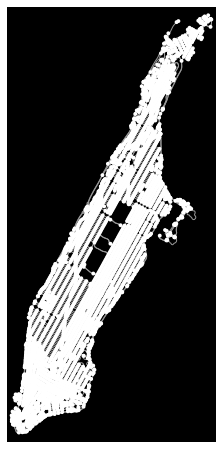

In [3]:
# New York map for processing
G = ox.graph_from_place('Manhattan, New York City, New York, USA', network_type='drive')
print(type(G))
fig, ax = ox.plot_graph(G, node_zorder=2, node_color='w', bgcolor='k')


In [4]:
# impute missing edge speeds then calculate edge travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [15]:
#ox.stats.basic_stats(G)

In [16]:
# Adding df2013['src'] & df2013['dst']
# get the nearest network nodes to two points
df2013['src'] = ox.distance.nearest_nodes(G, df2013['pickup_longitude'], df2013['pickup_latitude']) 
df2013['dst'] = ox.distance.nearest_nodes(G, df2013['dropoff_longitude'], df2013['dropoff_latitude'])

In [17]:
df2013.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,src,dst
8383812,2013-05-01 00:00:01,2013-05-01 00:05:12,-73.991351,40.727725,-73.979983,40.743117,1773121034,42445413
8396869,2013-05-01 00:00:01,2013-05-01 00:06:36,-73.975554,40.751772,-73.955469,40.768755,42446971,42438805
8388444,2013-05-01 00:00:01,2013-05-01 00:11:14,-74.007528,40.740975,-73.988808,40.745034,42429412,42428223
7713737,2013-05-01 00:00:03,2013-05-01 00:20:39,-74.006689,40.744307,-73.926799,40.765889,42439286,1331391393
8407687,2013-05-01 00:00:03,2013-05-01 00:07:38,-73.981092,40.759499,-73.958245,40.772842,42430356,42446472


In [18]:
# Drop unwanted columns
df2013=df2013.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','dropoff_datetime'])

In [19]:
# Checking if every src node and every dst node are indeed in our graph G
validity = True
graph_nodes = G.nodes()
for s_id in df2013['src']:
    if s_id not in graph_nodes:
        validity = Flase  
    
for s_id in df2013['dst']:
    if s_id not in graph_nodes:
        validity = Flase
if validity:
    print('src and dst are valid')
else:
    print('There is a bad src or dst')

src and dst are valid


In [20]:
# Saving the df as csv
df2013.to_csv('clean_2013.csv' , index=True)

In [21]:
# Shortest paths map generator

In [22]:
#Testing if shortest paths match
route = nx.shortest_path(G, 1773121034, 42445413, 'travel_time')
print(route)
#route_map = ox.plot_route_folium(G, route)

[1773121034, 4015190382, 42434196, 42434140, 42443296, 42449017, 42430886, 42449886, 42446533, 42436941, 42440729, 42431459, 42449890, 42446875, 42437283, 42449893, 42439170, 390519635, 42440326, 42448701, 42436586, 4138911201, 42429896, 42449918, 42446275, 42436753, 42445413]


In [10]:
travel_times = dict(nx.all_pairs_bellman_ford_path_length(G,weight='travel_times'))

In [11]:
print(len(travel_times))

4601


In [5]:
path = dict(nx.all_pairs_bellman_ford_path(G),weight='travel_times')


In [7]:
path_0 = []
path_1 = []
path_2 = []
path_3 = []
path_4 = []
path_5 = []
path_6 = []
path_7 = []
path_8 = []
path_9 = []

len_path_div_by_ten = len(path)//10

path_0 = dict(list(path.items())[len_path_div_by_ten * 0 :len_path_div_by_ten * 1])
path_1 = dict(list(path.items())[len_path_div_by_ten * 1 :len_path_div_by_ten * 2])
path_2 = dict(list(path.items())[len_path_div_by_ten * 2 :len_path_div_by_ten * 3])
path_3 = dict(list(path.items())[len_path_div_by_ten * 3 :len_path_div_by_ten * 4])
path_4 = dict(list(path.items())[len_path_div_by_ten * 4 :len_path_div_by_ten * 5])
path_5 = dict(list(path.items())[len_path_div_by_ten * 5 :len_path_div_by_ten * 6])
path_6 = dict(list(path.items())[len_path_div_by_ten * 6 :len_path_div_by_ten * 7])
path_7 = dict(list(path.items())[len_path_div_by_ten * 7 :len_path_div_by_ten * 8])
path_8 = dict(list(path.items())[len_path_div_by_ten * 8 :len_path_div_by_ten * 9])
path_9 = dict(list(path.items())[len_path_div_by_ten * 9 :])



In [12]:
with open('all_paths_nyc_part0.pickle', 'wb') as handle:
    pickle.dump(path_0, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_paths_nyc_part1.pickle', 'wb') as handle:
    pickle.dump(path_1, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_paths_nyc_part2.pickle', 'wb') as handle:
    pickle.dump(path_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_paths_nyc_part3.pickle', 'wb') as handle:
    pickle.dump(path_3, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_paths_nyc_part4.pickle', 'wb') as handle:
    pickle.dump(path_4, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_paths_nyc_part5.pickle', 'wb') as handle:
    pickle.dump(path_5, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_paths_nyc_part6.pickle', 'wb') as handle:
    pickle.dump(path_6, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_paths_nyc_part7.pickle', 'wb') as handle:
    pickle.dump(path_7, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_paths_nyc_part8.pickle', 'wb') as handle:
    pickle.dump(path_8, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_paths_nyc_part9.pickle', 'wb') as handle:
    pickle.dump(path_9, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
#print(path[1773121034][42445413])
print(type(path))

In [13]:
#Saving the path map
with open('all_paths_nyc.pickle', 'wb') as handle:
    pickle.dump(path, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [27]:
#Saving the travel_times map
with open('all_travel_times.pickle', 'wb') as handle:
    pickle.dump(travel_times, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('all_paths_nyc.pickle ', 'rb') as handle:
   b = pickle.load(handle)


In [10]:
# with open('all_paths_nyc.joblib', 'wb') as handle:
#     joblib.dump(path, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('all_paths_nyc.joblib', 'rb') as handle:
#    b = joblib.load(handle)

In [5]:
def load_pickle(filename, data):
    import cPickle as pickle
    with open(filename, 'rb') as file:
        data_pkl = pickle.load(file)
    for key, val in data_pkl.iteritems():
        data[key] = val

In [7]:
manager = Manager()
data_dict = manager.dict()
p = Process(target=load_pickle, args=("all_travel_times.pickle", data_dict))
p.start()
p.join()
print (len(data_dict))

0
